In [1]:
from __future__ import division
import argparse
import copy
import os
import os.path as osp
import time

import mmcv
import torch
from mmcv import Config
from mmcv.runner import init_dist

from mmdet import __version__
from mmdet.apis import set_random_seed, train_detector
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.utils import collect_env, get_root_logger

In [2]:
import cv2
import cv2 as cv
import imutils
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F

# Add code to sys.path
import matplotlib.pyplot as plt 

from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
import cv2 as cv
import collections

import dla.src.table_structure_analysis as tsa
import dla.src.xml_utils as xml_utils
from dla.src.image_utils import put_box, put_line
import pytesseract
import numpy as np

from statistics import mean

import importlib
import glosat_utils
importlib.reload(glosat_utils)

from glosat_utils import *

In [3]:
import os.path as osp
import xml.etree.ElementTree as ET
from PIL import Image

import dla.src.table_structure_analysis as tsa
import dla.src.xml_utils as xml_utils
from dla.src.image_utils import put_box, put_line

import pickle as pkl
import numpy as np

###  Image processing module

In [4]:
from glosat_utils import *

### Table bbox

In [5]:
config_file = '/data/glosat/glosat_table_dataset/dla/config/cascadeRCNN.py'
table_checkpoint_file = '/data/glosat/glosat_table_dataset/dla_models/model_table_det_full_table_train/best_model.pth'
cell_checkpoint_file = '/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train_corrected_cell/best_model.pth'
coarse_cell_checkpoint_file = '/data/glosat/glosat_table_dataset/dla_models/model_table_struct_coarse_train_corrected_cell/best_model.pth'

model = init_detector(config_file, table_checkpoint_file, device='cuda:0')
cell_model = init_detector(config_file, cell_checkpoint_file, device='cuda:0')
coarse_model = init_detector(config_file, coarse_cell_checkpoint_file, device='cuda:0')

THRESHOLD = 0.5
CLASSES = ("table_body","cell","full_table","header","heading")
color = 255

directory = '/data/glosat/glosat_table_dataset/datasets/Train/JPEGImages'
outdirectory = '/data/glosat/Code-Git/docExtractor-master/demo/Output-corrected-cell'

In [6]:
from os import path

In [7]:
files = os.listdir(directory)
cell_cordinates_info = {}
filename = '99'

In [8]:
if not path.exists(outdirectory):
    os.mkdir(outdirectory)
    
outpath = f'{outdirectory}/{filename}'
if not path.exists(outpath):
    os.mkdir(outpath)

### Cell structure annotation

In [14]:
cell_config_file = 'dla/config/cascadeRCNN_ignore_all_but_cells.py'
cfg = Config.fromfile(cell_config_file)
cfg.work_dir = '/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train'
cfg.gpu_ids = range(1) 
distributed = False

# mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime())
log_file = osp.join(cfg.work_dir, '{}.log'.format(timestamp))
logger = get_root_logger(log_file=log_file, log_level=cfg.log_level)

meta = dict()
# log env info
env_info_dict = collect_env()
env_info = '\n'.join([('{}: {}'.format(k, v))
                      for k, v in env_info_dict.items()])
dash_line = '-' * 60 + '\n'
logger.info('Environment info:\n' + dash_line + env_info + '\n' +
            dash_line)
meta['env_info'] = env_info

# log some basic info
logger.info('Distributed training: {}'.format(distributed))
logger.info('Config:\n{}'.format(cfg.text))

cfg.seed = 42
meta['seed'] = 42


model = build_detector(
    cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

2022-11-04 14:02:03,940 - mmdet - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.7.13 (default, Mar 29 2022, 02:18:16) [GCC 7.5.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.5.r11.5/compiler.30672275_0
GPU 0: Quadro RTX 6000
GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
PyTorch: 1.4.0
PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.21.1 (Git Hash 7d2fd500bc78936d1d648ca713b901012f470dbc)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute

2022-11-04 14:02:04,333 - mmdet - INFO - load model from: open-mmlab://msra/hrnetv2_w32
2022-11-04 14:02:04,667 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: incre_modules.0.0.conv1.weight, incre_modules.0.0.bn1.weight, incre_modules.0.0.bn1.bias, incre_modules.0.0.bn1.running_mean, incre_modules.0.0.bn1.running_var, incre_modules.0.0.bn1.num_batches_tracked, incre_modules.0.0.conv2.weight, incre_modules.0.0.bn2.weight, incre_modules.0.0.bn2.bias, incre_modules.0.0.bn2.running_mean, incre_modules.0.0.bn2.running_var, incre_modules.0.0.bn2.num_batches_tracked, incre_modules.0.0.conv3.weight, incre_modules.0.0.bn3.weight, incre_modules.0.0.bn3.bias, incre_modules.0.0.bn3.running_mean, incre_modules.0.0.bn3.running_var, incre_modules.0.0.bn3.num_batches_tracked, incre_modules.0.0.downsample.0.weight, incre_modules.0.0.downsample.1.weight, incre_modules.0.0.downsample.1.bias, incre_modules.0.0.downsample.1.running_mean, incre

In [29]:
datasets = [build_dataset(cfg.data.train)]
data = datasets.pop()

In [30]:
data.img_prefix  #training image filename

'/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/'

In [31]:
img_ids = mmcv.list_from_file(data.ann_file)

In [33]:
img_ids

['0',
 '1',
 '2',
 '3',
 '4',
 '6',
 '7',
 '9',
 '10',
 '11',
 '12',
 '13',
 '15',
 '16',
 '18',
 '20',
 '23',
 '24',
 '25',
 '27',
 '29',
 '31',
 '32',
 '33',
 '34',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '45',
 '46',
 '47',
 '48',
 '50',
 '52',
 '53',
 '54',
 '55',
 '57',
 '58',
 '59',
 '60',
 '64',
 '65',
 '66',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '87',
 '88',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '97',
 '98',
 '99',
 '100',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '109',
 '110',
 '111',
 '112',
 '116',
 '117',
 '118',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '148',
 '150',
 '151',
 '153',
 '154',
 '155',
 '157',
 '158',
 '161',
 '162',
 '163',
 '164',
 '165',
 '168',
 '169',
 '170',
 '171',
 '174',
 '176',
 '178',
 '179',
 '180',
 '181',
 '183',
 '184',
 '

In [34]:
img_infos = []
for img_id in img_ids:
    filename = 'JPEGImages/{}.jpg'.format(img_id)
    img_path = osp.join(data.img_prefix, 'JPEGImages',
                            '{}.jpg'.format(img_id))
    img = Image.open(img_path)
    width, height = img.size
    img_infos.append(
        dict(id=img_id, filename=filename, width=width, height=height))

In [35]:
from os.path import exists

In [25]:
def get_coordinates_cells(cells, pc):    
    cells_x = []
    cells_y = []
    x = 0
    y = 0
    for cell in cells:
        if cell[0] not in cells_x:
            cells_x.append(cell[0])
        if cell[2] not in cells_x:
            cells_x.append(cell[2])
        if cell[1] not in cells_y:
            cells_y.append(cell[1])
        if cell[3] not in cells_y:
            cells_y.append(cell[3])

    cells_x = sorted(cells_x)
    cells_y = sorted(cells_y)
    cell_cordinates, average_cordinates = get_coordinates([[cells_x,cells_y]],pc)
    return cell_cordinates, average_cordinates

def check_cell(cell,average_cordinates):
    tid = cell[4]
    avg_x, avg_y = average_cordinates[-1]

    if abs(cell[0]-cell[2])>avg_x * 0.8 and abs(cell[1]-cell[3])> avg_y * 0.8 and cell[0]<cell[2] and cell[1]< cell[3]:
        return True
    else:
        return False

In [38]:
idx=0
work_dir = '/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train'

In [50]:
while idx<len(img_infos):
    img_id = img_infos[idx]['id']

    xml_path = osp.join(data.img_prefix, 'Annotations',
                        '{}.xml'.format(img_id))
    tree = ET.parse(xml_path)
    root = tree.getroot()
    bboxes = []
    labels = []
    bboxes_ignore = []
    labels_ignore = []
    det_type = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        det_type.append(name)
        label = data.cat2label[name]
        difficult = int(obj.find('difficult').text)
        bnd_box = obj.find('bndbox')
        # Coordinates may be float type
        bbox = [
            int(float(bnd_box.find('xmin').text)),
            int(float(bnd_box.find('ymin').text)),
            int(float(bnd_box.find('xmax').text)),
            int(float(bnd_box.find('ymax').text))
        ]
        ignore = name in data.ignore
        if data.min_size:
            assert not self.test_mode
            w = bbox[2] - bbox[0]
            h = bbox[3] - bbox[1]
            if w < data.min_size or h < data.min_size:
                ignore = True
        if difficult or ignore:
            bboxes_ignore.append(bbox)
            labels_ignore.append(label)
        else:
            bboxes.append(bbox+[1])
            labels.append(label)

    try:
        if 'cell' in det_type:
            active_lr_path = osp.join(data.img_prefix, 'bbox_new_gen','{}_cell_bounding_box_v2.pkl'.format(img_id))
            file_exists = exists(active_lr_path)
            if file_exists:
                f = open(active_lr_path,'rb')
                info = pkl.load(f)
                (correct_cells, blank_cells_new, exclude_cells_new, tables, masks) =  info
                f.close()  

                table_cells = get_x_y_initial(tables, bboxes, 0.5)
                cell_cordinates, average_cordinates = get_coordinates(table_cells,0.7)

                # Average table cell in a page if multiple table exists 
                x_avg = []
                y_avg = []
                for xa,ya in average_cordinates:
                    x_avg.append(xa)
                    y_avg.append(ya)
                average_cordinates.append((mean(x_avg),mean(y_avg)))
                correct_cells, possible_correct_cells = find_overlapped_cell_final(bboxes, correct_cells+blank_cells_new, average_cordinates)

                boxes = []
                for cell in correct_cells:
                    if check_cell(cell,average_cordinates):
                        boxes.append(cell[0:4]+[1])

                bboxes += boxes
                labels += [label]*len(boxes)

                del correct_cells, possible_correct_cells
            
    except:
        print(f"{work_dir}/VOC2007/train_annotation_refined/{img_infos[idx]['filename'].split('/')[1]}")

    print(len(bboxes),len(labels))
    
    if not bboxes:
        bboxes = np.zeros((0, 4))
        labels = np.zeros((0, ))
    else:
        bboxes = np.array(bboxes, ndmin=2) - 1
        labels = np.array(labels)
    if not bboxes_ignore:
        bboxes_ignore = np.zeros((0, 4))
        labels_ignore = np.zeros((0, ))
    else:
        bboxes_ignore = np.array(bboxes_ignore, ndmin=2) - 1
        labels_ignore = np.array(labels_ignore)

    ann = dict(
        bboxes=bboxes.astype(np.float32),
        labels=labels.astype(np.int64),
        bboxes_ignore=bboxes_ignore.astype(np.float32),
        labels_ignore=labels_ignore.astype(np.int64))

    img_path = osp.join(data.img_prefix, img_infos[idx]['filename'])
    img = cv.imread(img_path)
    image, height, width, _ = image_preprocessing(img)
    
    color = 255
    for box in bboxes:
        box = list(map(int, box[0:4]))
        put_box(image,box,(0,0,color)) # blue 

    for box in ann['bboxes_ignore']:
        box = list(map(int, box[0:4]))
        put_box(image,box,(color,0,0)) # Red 

    im_pil = Image.fromarray(image)
    im_pil.save(f"{work_dir}/VOC2007/train_annotation_refined/{img_infos[idx]['filename'].split('/')[1]}")
    idx+=1
    
    del ann, bboxes, root, tree

838 838
1324 1324
664 664
/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/train_annotation_refined/33.jpg
377 377
870 870
24 24
377 377
145 145
149 149
866 866
24 24
24 24
1185 1185
1332 1332
1128 1128
24 24
24 24
/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/train_annotation_refined/50.jpg
377 377
24 24
710 710
149 149
1110 1110
151 151
/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/train_annotation_refined/58.jpg
377 377
24 24
1313 1313
1134 1134
/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/train_annotation_refined/65.jpg
377 377
147 147
/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/train_annotation_refined/69.jpg
377 377
868 868
866 866
1058 1058
147 147
866 866
321 321
1348 1348
1121 1121
331 331
146 146
149 149
922 922
168 168
239 239
168 168
234 234
168 168
204 204
239 239
204 204
168 168
168 168
213

In [40]:
idx = 20
img_id = data.img_infos[idx]['id']
xml_path = osp.join(data.img_prefix, 'Annotations',
                    '{}.xml'.format(img_id))
tree = ET.parse(xml_path)
root = tree.getroot()
bboxes = []
labels = []
bboxes_ignore = []
labels_ignore = []
for obj in root.findall('object'):
    name = obj.find('name').text
    label = data.cat2label[name]
    difficult = int(obj.find('difficult').text)
    bnd_box = obj.find('bndbox')
    # Coordinates may be float type
    bbox = [
        int(float(bnd_box.find('xmin').text)),
        int(float(bnd_box.find('ymin').text)),
        int(float(bnd_box.find('xmax').text)),
        int(float(bnd_box.find('ymax').text))
    ]
    ignore = name in data.ignore
    if data.min_size:
        assert not data.test_mode
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        if w < data.min_size or h < data.min_size:
            ignore = True
    if difficult or ignore:
        bboxes_ignore.append(bbox)
        labels_ignore.append(label)
    else:
        bboxes.append(bbox)
        labels.append(label)
bboxes

[[137, 645, 256, 714],
 [256, 645, 480, 714],
 [480, 645, 570, 714],
 [570, 645, 646, 714],
 [646, 645, 716, 714],
 [716, 645, 790, 714],
 [790, 645, 880, 714],
 [880, 645, 1000, 714],
 [1000, 645, 1078, 714],
 [1078, 645, 1140, 714],
 [1140, 645, 1202, 714],
 [1202, 645, 1296, 714],
 [1296, 645, 1380, 714],
 [1380, 645, 1452, 714],
 [1452, 645, 1548, 714],
 [1548, 645, 1594, 714],
 [1594, 645, 1700, 714],
 [1700, 645, 1770, 714],
 [1770, 645, 1832, 714],
 [1832, 645, 1886, 714],
 [1886, 645, 1990, 714],
 [137, 714, 256, 778],
 [256, 714, 480, 778],
 [480, 714, 570, 778],
 [570, 714, 646, 778],
 [646, 714, 716, 778],
 [716, 714, 790, 778],
 [790, 714, 880, 778],
 [880, 714, 1000, 778],
 [1000, 714, 1078, 778],
 [1078, 714, 1140, 778],
 [1140, 714, 1202, 778],
 [1202, 714, 1296, 778],
 [1296, 714, 1380, 778],
 [1380, 714, 1452, 778],
 [1452, 714, 1548, 778],
 [1548, 714, 1594, 778],
 [1594, 714, 1700, 778],
 [1700, 714, 1770, 778],
 [1770, 714, 1832, 778],
 [1832, 714, 1886, 778],
 [188

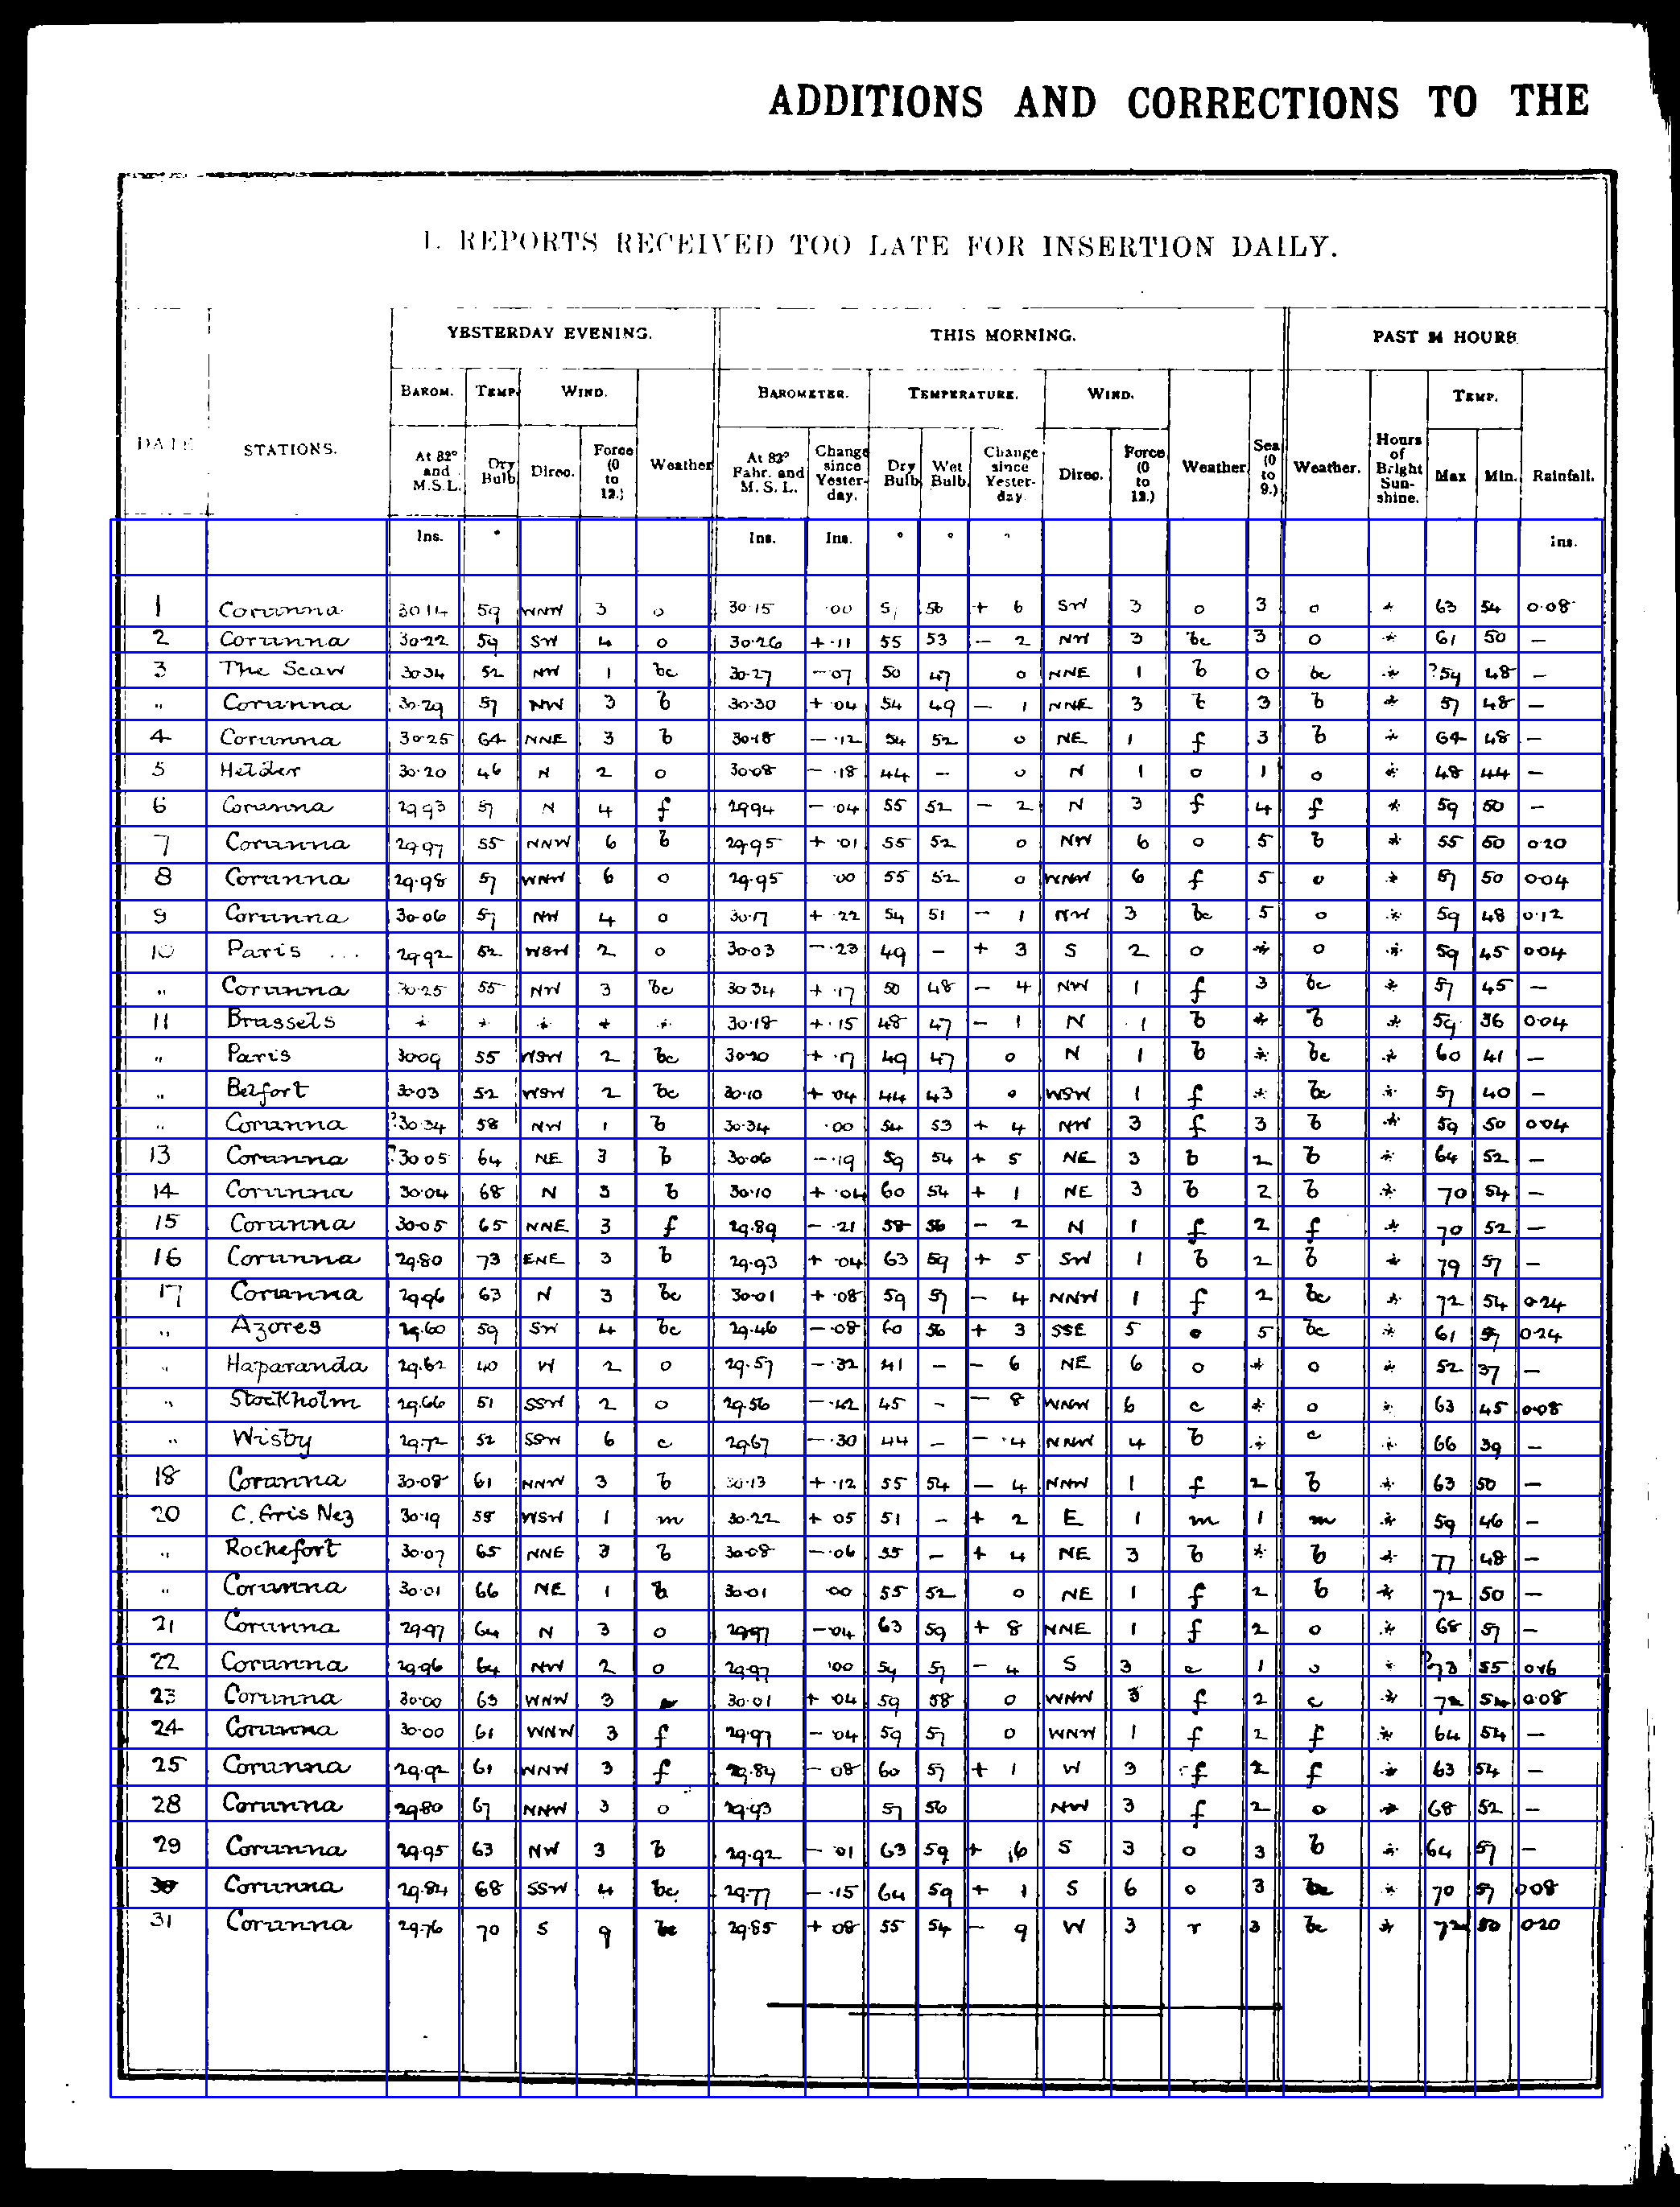

In [42]:
bboxes
img_path = osp.join(data.img_prefix, img_infos[idx]['filename'])
img = cv.imread(img_path)
image, height, width, _ = image_preprocessing(img)

color = 255

for box in bboxes:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,0,color)) # blue 
    
# for box in boxes:
#     box = list(map(int, box[0:4]))
#     put_box(image,box,(0,color,0)) # green 


im_pil = Image.fromarray(image)
im_pil

### New cell bbox addition

In [43]:
active_lr_path = osp.join(data.img_prefix, 'bbox_new_gen','{}_cell_bounding_box_v2.pkl'.format(img_id))
active_lr_path

'/data/glosat/glosat_table_dataset/dla_models/model_table_struct_fine_train/VOC2007/bbox_new_gen/29_cell_bounding_box_v2.pkl'

In [44]:
f = open(active_lr_path,'rb')
info = pkl.load(f)
(correct_cells, blank_cells_new, exclude_cells_new, tables, masks) =  info
f.close()

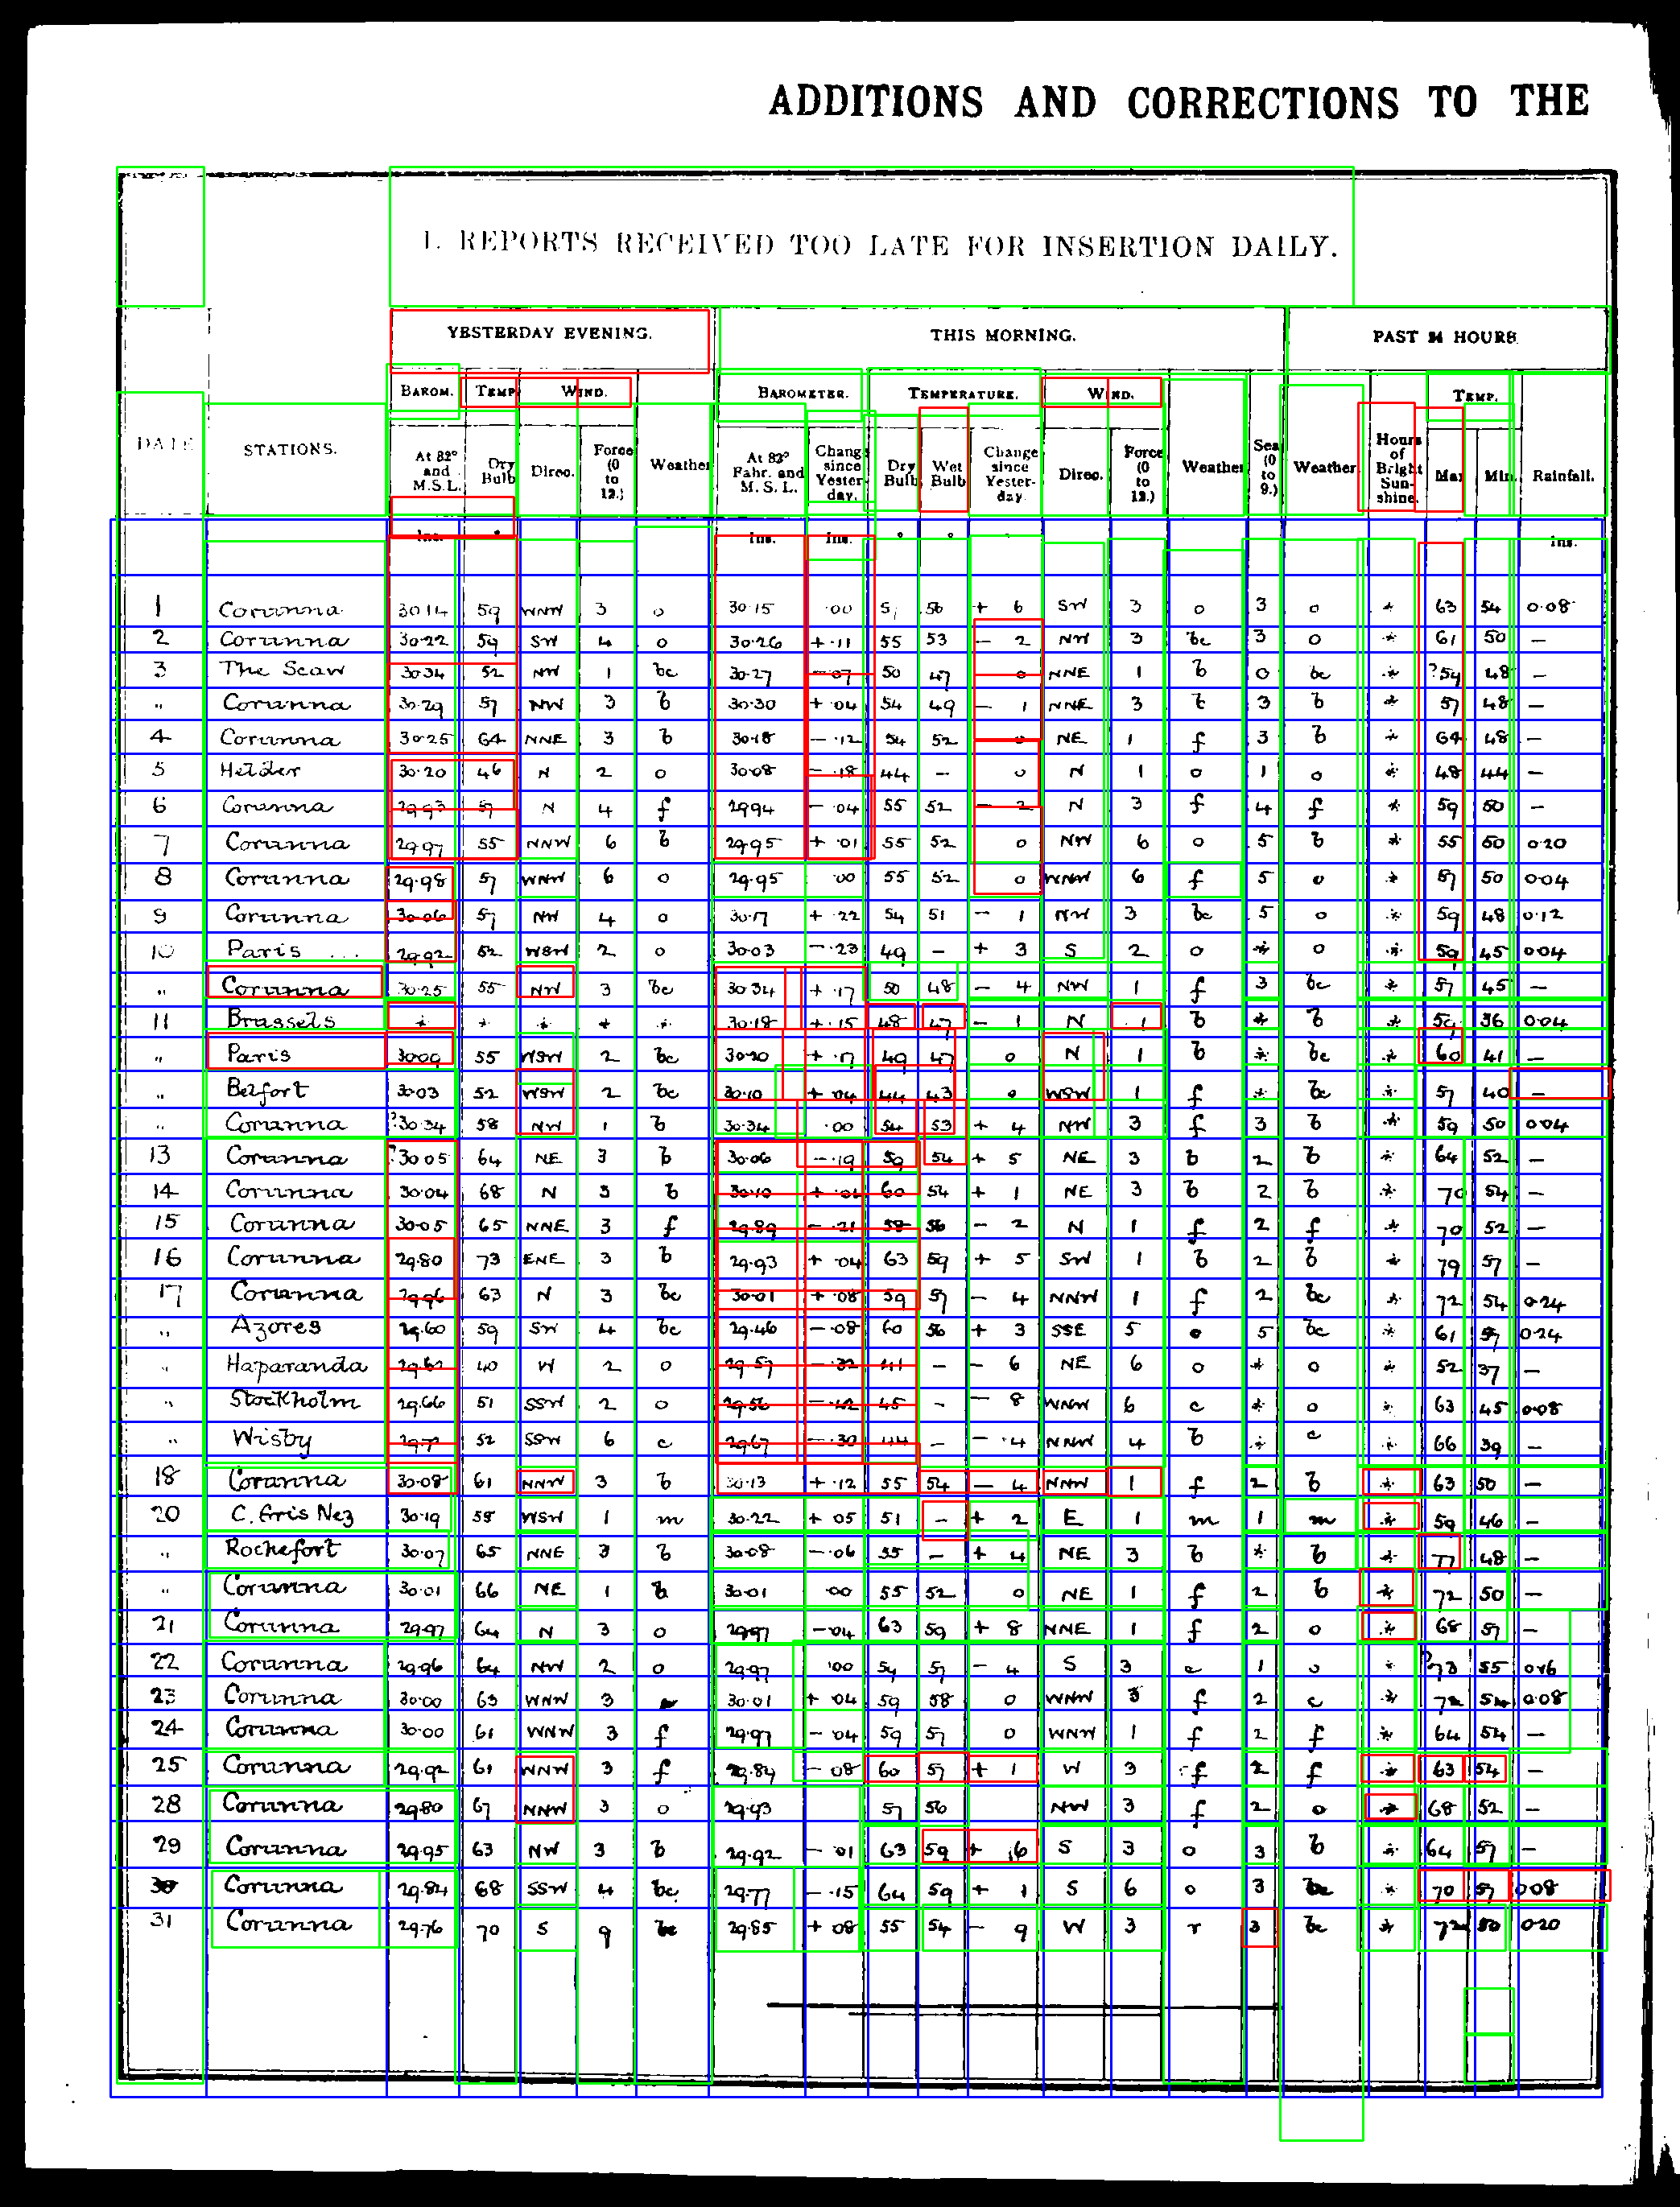

In [45]:
color = 255
for box in correct_cells:
    box = list(map(int, box[0:4]))
    put_box(image,box,(0,color,0)) # green 
    
for box in exclude_cells_new:
    box = list(map(int, box[0:4]))
    put_box(image,box,(color,0,0)) # red 

im_pil = Image.fromarray(image)
im_pil 

In [46]:
xml_path = osp.join(data.img_prefix, 'Annotations',
                    '{}.xml'.format(img_id))
tree = ET.parse(xml_path)
root = tree.getroot()
bboxes = []
labels = []
bboxes_ignore = []
labels_ignore = []
for obj in root.findall('object'):
    name = obj.find('name').text
    label = data.cat2label[name]
    difficult = int(obj.find('difficult').text)
    bnd_box = obj.find('bndbox')
    # Coordinates may be float type
    bbox = [
        int(float(bnd_box.find('xmin').text)),
        int(float(bnd_box.find('ymin').text)),
        int(float(bnd_box.find('xmax').text)),
        int(float(bnd_box.find('ymax').text))
    ]
    ignore = name in data.ignore
    if data.min_size:
        assert not self.test_mode
        w = bbox[2] - bbox[0]
        h = bbox[3] - bbox[1]
        if w < data.min_size or h < data.min_size:
            ignore = True
    if difficult or ignore:
        bboxes_ignore.append(bbox)
        labels_ignore.append(label)
    else:
        bboxes.append(bbox)
        labels.append(label)

if name == 'cell':
    active_lr_path = osp.join(data.img_prefix, 'bbox_new_gen','{}_cell_bounding_box_v2.pkl'.format(img_id))
    f = open(active_lr_path,'rb')
    info = pkl.load(f)
    (correct_cells, blank_cells_new, exclude_cells_new, tables, masks) =  info
    f.close()
    for cell in correct_cells:
        bboxes.append(cell[0:4])
    labels+[label]*len(correct_cells)
    
type(bboxes)

list

In [47]:
difficult

0

In [48]:
if not bboxes:
    bboxes = np.zeros((0, 4))
    labels = np.zeros((0, ))
else:
    bboxes = np.array(bboxes, ndmin=2) - 1
    labels = np.array(labels)

if not bboxes_ignore:
    bboxes_ignore = np.zeros((0, 4))
    labels_ignore = np.zeros((0, ))
else:
    bboxes_ignore = np.array(bboxes_ignore, ndmin=2) - 1
    labels_ignore = np.array(labels_ignore)


In [49]:
ann = dict(
    bboxes=bboxes.astype(np.float32),
    labels=labels.astype(np.int64),
    bboxes_ignore=bboxes_ignore.astype(np.float32),
    labels_ignore=labels_ignore.astype(np.int64))
ann

{'bboxes': array([[ 136.,  644.,  255.,  713.],
        [ 255.,  644.,  479.,  713.],
        [ 479.,  644.,  569.,  713.],
        ...,
        [ 259., 2223.,  567., 2313.],
        [ 470., 2323.,  567., 2418.],
        [ 262., 2323.,  564., 2418.]], dtype=float32),
 'labels': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 